# Get generated images with highest PSNR/Similarity

### The higher the value of PSNR (in decibels/dB), the better the reconstruction quality
### SSIM ranges between 0 and 1, where a higher value indicates greater structural coherence and thus better Dehazing results

In [38]:
import numpy as np
from math import log10
from skimage.metrics import structural_similarity as ssim
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
from PIL import Image
import os
from database2 import DehazingDataset
import matplotlib.pyplot as plt
from skimage.transform import resize

In [10]:
%pip install scikit-image

  Using cached scikit_image-0.23.1-cp312-cp312-macosx_12_0_arm64.whl.metadata (14 kB)
  Using cached imageio-2.34.0-py3-none-any.whl.metadata (4.9 kB)
  Using cached tifffile-2024.4.18-py3-none-any.whl.metadata (31 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
Using cached scikit_image-0.23.1-cp312-cp312-macosx_12_0_arm64.whl (13.3 MB)
Using cached imageio-2.34.0-py3-none-any.whl (313 kB)
Using cached lazy_loader-0.4-py3-none-any.whl (12 kB)
Using cached tifffile-2024.4.18-py3-none-any.whl (224 kB)
  Attempting uninstall: lazy-loader
    Found existing installation: lazy_loader 0.3
    Uninstalling lazy_loader-0.3:
      Successfully uninstalled lazy_loader-0.3
Note: you may need to restart the kernel to use updated packages.


In [58]:
def PSNR(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:  
        return 100
    max_pixel = 255.0
    psnr = 10 * log10(max_pixel**2 / mse)
    return psnr

def visualize_top_images(psnr, top_x):
    # BASED ON HIGHEST PSNR
    if psnr == 1:
        top_images = [generated_images[i] for i in sorted_indices_psnr[:top_x]]
    else: # BASED ON HIGHEST SSIM
        top_images = [generated_images[i] for i in sorted_indices_ssim[:top_x]]

    fig, axes = plt.subplots(1, top_x, figsize=(15, 5))
    for i in range(top_x):
        image = top_images[i].transpose(1, 2, 0)
        image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Denormalize
        # Transpose dimensions from (3, 256, 256) to (256, 256, 3)
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(f"Image {i+1}")

    plt.tight_layout()
    plt.show()




class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
        
# similarity = ssim(img1, img2)

In [14]:
root_dir = 'Task2Dataset'
train_dir = os.path.join(root_dir, 'train')
val_dir = os.path.join(root_dir, 'val')
transform = transforms.Compose([
                                #  transforms.Resize((224, 224)), # ASSUMING NO NEED FOR RESIZING AS ALL IMAGES ARE ALREADY 256*256
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                 ])

train_dataset = DehazingDataset(train_dir, transform)
val_dataset = DehazingDataset(val_dir, transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

In [84]:
# INITIALISE AND LOAD WEIGHTS TO A GENERATOR

generator = Generator()

weights_path = 'generator_l1loss_scheduler.pth'

# Load the weights into the generator model
generator.load_state_dict(torch.load(weights_path))

# Set the generator to evaluation mode
generator.eval()

Generator(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): 

In [52]:


# Iterate through hazy images and compute PSNR or SSIM for each generated image
psnr_scores = []
ssim_scores = []
generated_images = []

for hazy_imgs, clean_imgs in tqdm(train_dataloader, desc='Computing Metrics'):
    # Generate images using your GAN model (replace this with your GAN inference code)
    generated_imgs = generator(hazy_imgs)
    
    # Compute PSNR and SSIM for each pair of generated and clean images in the batch
    for generated_img, clean_img in zip(generated_imgs, clean_imgs):
        # Convert tensors to numpy arrays
        generated_img_np = generated_img.detach().cpu().numpy()
        clean_img_np = clean_img.detach().cpu().numpy()

        clean_image = images[i].permute(1, 2, 0).cpu().numpy()  # Convert to NumPy array
        clean_image = clean_image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Denormalize
        

        # Store for later visualisation
        generated_images.append(generated_img_np)
        
        # Compute PSNR
        psnr = PSNR(generated_img_np, clean_img_np)
        psnr_scores.append(psnr)
        
        # Compute SSIM
        # resized_generated_img_np = resize(generated_img_np, clean_img_np.shape)
        # ssimilarity = ssim(resized_generated_img_np, clean_img_np, multichannel=True)
        # ssim_scores.append(ssimilarity)

Computing Metrics: 100%|██████████████████████| 239/239 [05:11<00:00,  1.30s/it]


In [48]:
min_value = np.amin(clean_img_np)
max_value = np.amax(clean_img_np)

print("Minimum pixel value:", min_value)
print("Maximum pixel value:", max_value)

Minimum pixel value: -1.1589178
Maximum pixel value: 2.64


In [49]:
min_value = np.amin(generated_img_np)
max_value = np.amax(generated_img_np)

print("Minimum pixel value:", min_value)
print("Maximum pixel value:", max_value)

Minimum pixel value: -0.91406065
Maximum pixel value: 0.91081786


In [44]:
clean_img_np.shape

(3, 256, 256)

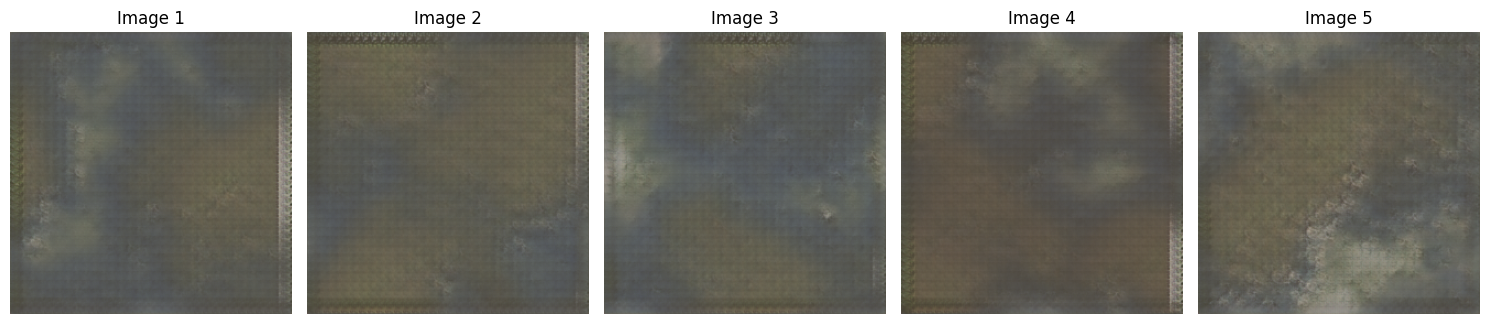

In [59]:
# Sort generated images based on PSNR or SSIM scores
# Choose PSNR or SSIM as per your requirement
sorted_indices_psnr = np.argsort(psnr_scores)[::-1]  # Sort in descending order
# sorted_indices_ssim = np.argsort(ssim_scores)[::-1]  # Sort in descending order

# Visualize top X images based on PSNR or SSIM
top_x = 5  # Change this value as needed
visualize_top_images(1, top_x)

In [94]:
def view_image(image_tensor):
    # Convert tensor to NumPy array and detach if required
    image = image_tensor.detach().permute(1, 2, 0).cpu().numpy()
    
    # Denormalize the image
    image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    
    # Plot the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


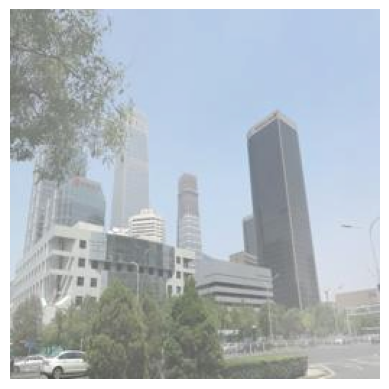

In [102]:
view_image(hazy_imgs[2])

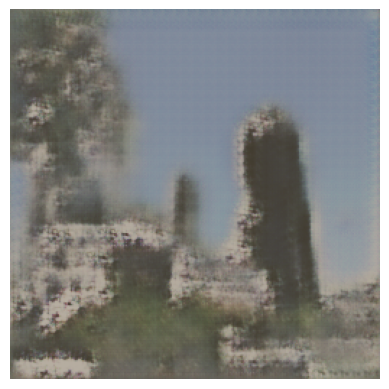

In [101]:
view_image(generator(hazy_imgs)[2])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


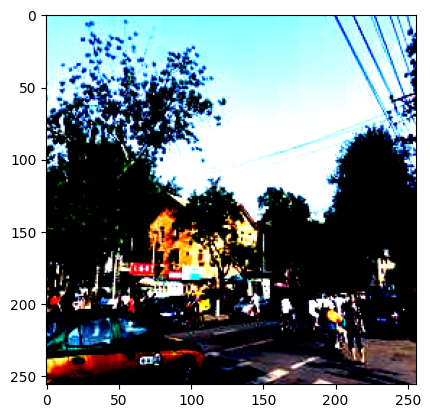

In [62]:
plt.imshow(clean_imgs[0].detach().numpy().transpose(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


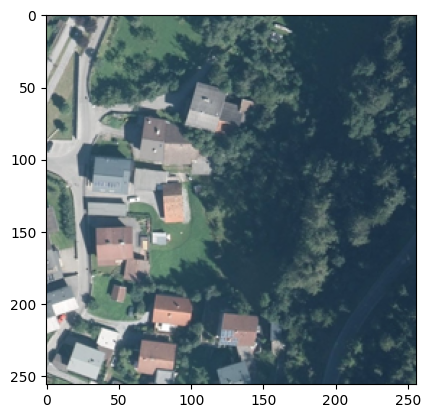

In [93]:
clean_image = clean_imgs[1].permute(1, 2, 0).cpu().numpy()  # Convert to NumPy array
clean_image = clean_image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Denormalize
plt.imshow(clean_image)

In [ ]:
def view_image(image):
    

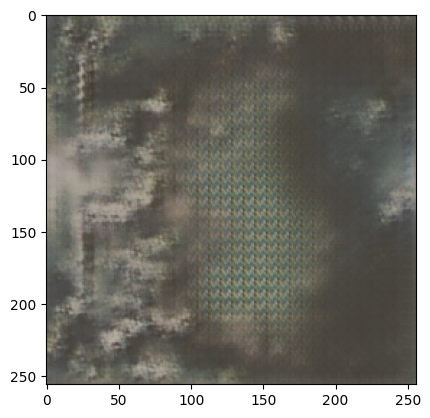

In [92]:

clean_image = generator(hazy_imgs)[1].detach().permute(1, 2, 0).cpu().numpy()  # Convert to NumPy array
clean_image = clean_image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Denormalize
plt.imshow(clean_image)

In [57]:
sorted(psnr_scores)

[43.27659831520862,
 44.08675591240205,
 44.11906528569609,
 44.12999339506486,
 44.175900135889805,
 44.22331876548461,
 44.29708178204606,
 44.368245311368256,
 44.37356630225369,
 44.37554449388904,
 44.43744221604917,
 44.511631348863,
 44.530970104975054,
 44.55780325511558,
 44.59416014710997,
 44.60793667105749,
 44.650895823922255,
 44.67581571057357,
 44.68006349942407,
 44.71973067607785,
 44.740814898963926,
 44.74649645703086,
 44.74737197043933,
 44.774465984230574,
 44.78706942264621,
 44.868941993822375,
 44.8869228599749,
 44.89514688623821,
 44.923705653371016,
 44.926255522862476,
 44.93041365406448,
 44.98751019829576,
 44.997400882140454,
 45.06590276844765,
 45.06942620671997,
 45.07943927867043,
 45.09252786653991,
 45.11998130461247,
 45.12458649350193,
 45.15101729004673,
 45.16054481533576,
 45.17847345887115,
 45.17974572273421,
 45.18979313460865,
 45.20350113607805,
 45.20732686089509,
 45.229360227922086,
 45.26019561811218,
 45.277314890129546,
 45.2779080

In [ ]:
clean_image = images[i].permute(1, 2, 0).cpu().numpy()  # Convert to NumPy array
clean_image = clean_image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Denormalize



In [ ]:
generated_im